In [1]:
import numpyro
from numpyro.infer import MCMC, NUTS, Predictive
import numpyro.distributions as dist
import jax
from jax import random
from jax import numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

import bambi as bmb

In [2]:
numpyro.set_platform("cpu")
numpyro.set_host_device_count(10)

# Model

In [58]:
# Seed for reproducibility
np.random.seed(42)

# Number of data points
n = 1000

# Generate synthetic data for predictor X
X = np.random.choice([0,1,2], n)
Z = np.random.choice([0,1,2,3,4,5,6,7,8,9,10], n)

X[:10]  # Display the first 10 values of X for reference

array([2, 0, 2, 2, 0, 0, 2, 1, 2, 2])

In [59]:
# Define alpha and beta
alpha = 11
beta_x = 0.5
beta_z = -0.3

# Compute the expected value of Y for each X using the linear predictor
E_Y_given_X = np.exp(alpha + beta_x * X + beta_z * Z)

E_Y_given_X[:10]  # Display the first 10 expected values of Y for reference

array([ 26903.1860743 ,  32859.62567444,  89321.72336081,  19930.37043823,
        18033.74492783,  24343.00942441,  19930.37043823,  22026.46579481,
       120571.71498645,  66171.16016838])

In [60]:
# Generate gamma-distributed Y values
scale = 1  # Scale parameter
Y = np.random.gamma(E_Y_given_X, scale)

Y[:10]  # Display the first 10 values of Y for reference

array([ 26560.66428853,  32905.38831683,  89515.47235922,  19734.16889256,
        18147.4039454 ,  24533.91099395,  19981.27842336,  22219.44367446,
       120457.91317828,  66029.20380281])

In [61]:
(Y / scale).mean()

36843.00941488199

<Axes: ylabel='Density'>

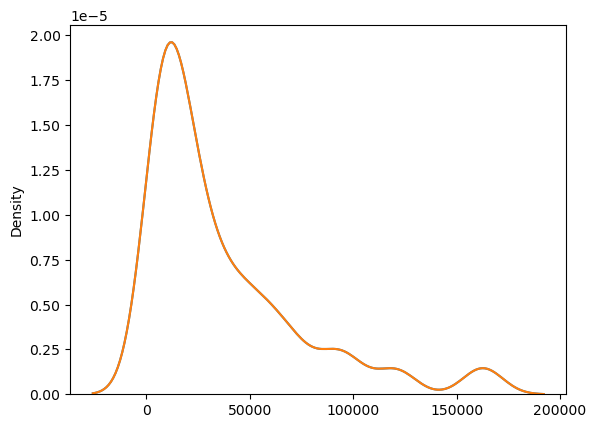

In [62]:
sns.kdeplot(Y)
sns.kdeplot(Y/scale)

## Statsmodels

In [63]:
import statsmodels.api as sm

# Add a constant to X to account for the intercept
X_with_const = sm.add_constant(np.stack([X, Z], axis=1))

# Fit a Gamma GLM
gamma_glm = sm.GLM(Y/scale, X_with_const, family=sm.families.Gamma(link=sm.families.links.log())).fit()

/home/avena/miniconda3/envs/bambi/lib/python3.11/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [64]:
gamma_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      997
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                      7.4317e-05
Method:                          IRLS   Log-Likelihood:                -6659.6
Date:                Mon, 04 Sep 2023   Deviance:                     0.074179
Time:                        22:10:08   Pearson chi2:                   0.0741
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0000      0.001    1.8e+04      0.000      10.999      11.001
x1             0.5000      0.000   1502.183      0.000       0.499       0.501
x2            -0.3001   8.57e-05  -3502.716      0.000      -0.300      -0.300
==============================================================================
"""

## Numpyro

In [67]:
def gamma_glm(x, z):
    alpha = numpyro.sample("alpha", dist.Normal(9, 1))
    beta_x = numpyro.sample("beta_x", dist.Normal(0, 1))
    beta_z = numpyro.sample("beta_z", dist.Normal(0, 1))
    shape = numpyro.sample("shape", dist.Uniform(0,10))

    mu = jnp.exp(alpha + beta_x * x + beta_z * z)
    rate = shape / mu    
    
    numpyro.sample("obs", dist.Gamma(concentration=shape, rate=rate), obs=Y)

# Run MCMC as before
rng_key = random.PRNGKey(0)
kernel = NUTS(gamma_glm)
mcmc = MCMC(kernel, num_warmup=4000, num_samples=2000, num_chains=4, chain_method='parallel')
mcmc.run(rng_key, X, Z)
mcmc.print_summary(exclude_deterministic=False)

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha     11.00      0.02     11.00     10.96     11.04   3407.71      1.00
    beta_x      0.50      0.01      0.50      0.48      0.52   4104.66      1.00
    beta_z     -0.30      0.00     -0.30     -0.31     -0.30   4033.07      1.00
     shape      9.98      0.02      9.99      9.95     10.00   6430.36      1.00

Number of divergences: 0


In [68]:
az.summary(az.from_numpyro(mcmc), round_to=5)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,10.99876,0.02235,10.95689,11.04035,0.00038,0.00027,3409.80431,4093.16162,1.00163
beta_x,0.50047,0.01231,0.47856,0.52444,0.00019,0.00014,4126.18801,4732.02235,1.00044
beta_z,-0.29988,0.00312,-0.30571,-0.29396,0.00005,0.00003,4063.72206,4428.74031,1.00096
shape,9.97990,0.02012,9.94347,10.00000,0.00025,0.00018,3973.20055,2467.29545,1.00077
